In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, r2_score

In [5]:
# Load CSV file
df = pd.read_csv('/amazon-2025-06-14.csv')


In [6]:
# Step 1: Extract key columns
clean_df = pd.DataFrame()
clean_df['Product Name'] = df['a-size-base-plus'].combine_first(df['a-size-base (2)'])
clean_df['Rating'] = df['a-icon-alt']
clean_df['Number of Reviews'] = df['a-size-small (2)']
clean_df['Price'] = df['a-offscreen']
clean_df['Image URL'] = df['s-image src']
clean_df['Size/Volume'] = df['a-size-base']
clean_df['Product Link'] = df['a-link-normal href (2)']

In [7]:
# Remove rows without product name
clean_df = clean_df.dropna(subset=['Product Name'])

In [8]:
# Step 2: Clean and convert fields
# Convert Rating to float
clean_df['Rating'] = clean_df['Rating'].str.extract(r'(\d+\.\d+)').astype(float)


In [9]:
# Convert Number of Reviews to numeric
clean_df['Number of Reviews'] = pd.to_numeric(clean_df['Number of Reviews'], errors='coerce')


In [12]:
# Clean Price column (INR format)
clean_df['Price (INR)'] = (
    clean_df['Price']
    .str.replace('INR', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
    .str.replace(' ', '')  # Remove non-breaking space
    )

In [14]:
clean_df['Price (INR)'] = pd.to_numeric(clean_df['Price (INR)'], errors='coerce')

# Step 3: Add custom labels
clean_df['Category'] = 'Face Wash'

In [16]:
def price_range(price):
    if pd.isna(price):
        return 'Unknown'
    elif price < 300:
        return 'Budget'
    elif 300 <= price <= 800:
        return 'Mid-Range'
    else:
        return 'Premium'

clean_df['Price Range'] = clean_df['Price (INR)'].apply(price_range)

In [17]:
def generate_tags(name):
    tags = []
    name = str(name).lower()
    if 'men' in name:
        tags.append('For Men')
    if 'acne' in name:
        tags.append('Anti-Acne')
    if 'foaming' in name:
        tags.append('Foam')
    if 'hydrating' in name or 'moisturizing' in name:
        tags.append('Hydrating')
    if 'salicylic' in name:
        tags.append('Salicylic Acid')
    if 'sensitive' in name:
        tags.append('Sensitive Skin')
    return ', '.join(tags) if tags else 'General'

clean_df['Tags'] = clean_df['Product Name'].apply(generate_tags)

In [18]:
# Step 4: Save cleaned data
clean_df.to_csv('cleaned_amazon_facewash.csv', index=False)

In [19]:
print(clean_df.head())

                                        Product Name  Rating  \
2  Neutrogena Fragrance Free Ultra Gentle Foaming...     4.6   
3  Clean & Clear 2-Pack Oil-Free Facial Cleansers...     4.6   
4  Neutrogena Ultra Gentle Cream-to-Foam Facial C...     4.5   
5  Tiege Hanley Daily Mens Face Wash, 5.5 Oz - Ge...     4.5   
6  Daily Mens Face Wash + Scrub - 5 Month Supply ...     4.4   

   Number of Reviews         Price  \
2                4.6  INR 1,022.20   
3                4.6    INR 831.88   
4                4.5    INR 858.58   
5                4.5           NaN   
6                4.4           NaN   

                                           Image URL            Size/Volume  \
2  https://m.media-amazon.com/images/I/61KMpNntDA...   16 Fl Oz (Pack of 1)   
3  https://m.media-amazon.com/images/I/71n9IZ2UU+...    8 Fl Oz (Pack of 1)   
4  https://m.media-amazon.com/images/I/61xSQWC5K8...   12 Fl Oz (Pack of 1)   
5  https://m.media-amazon.com/images/I/718yclm2Yq...  5.5 Fl Oz (Pack 


**Basic** **Visualizations**


Top 10 Most Reviewed Products

<ipython-input-21-290012611>:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


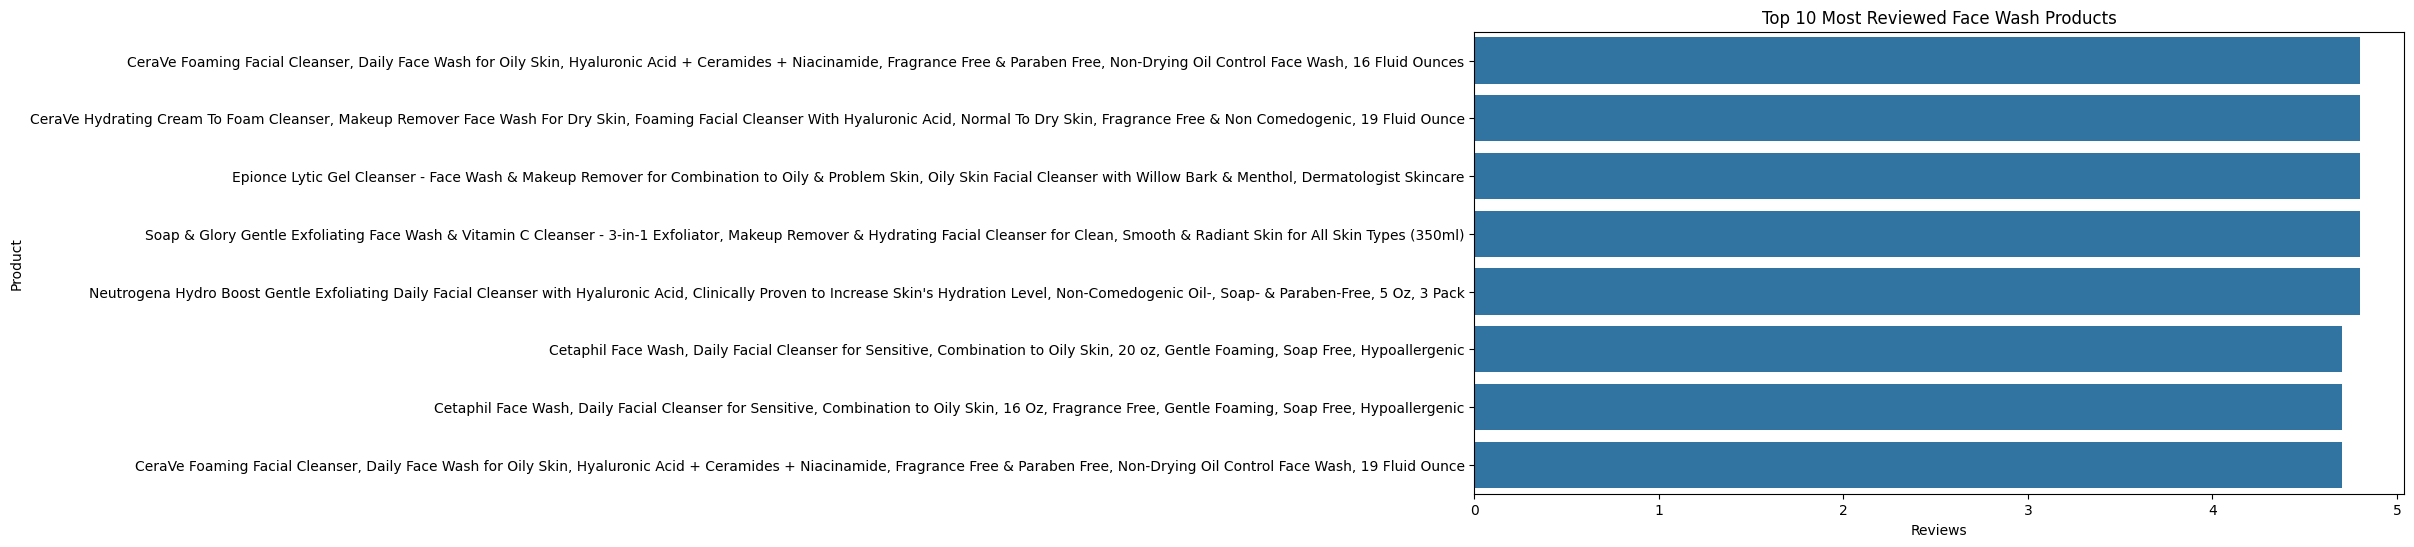

In [21]:
top_reviews = clean_df.sort_values('Number of Reviews', ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x='Number of Reviews', y='Product Name', data=top_reviews)
plt.title('Top 10 Most Reviewed Face Wash Products')
plt.xlabel('Reviews')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

 Price Distribution

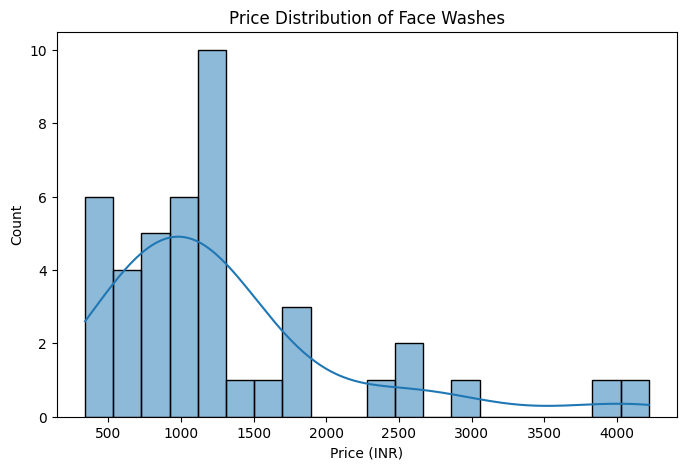

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(clean_df['Price (INR)'], bins=20, kde=True)
plt.title('Price Distribution of Face Washes')
plt.xlabel('Price (INR)')
plt.ylabel('Count')
plt.show()




Product Rating Distribution

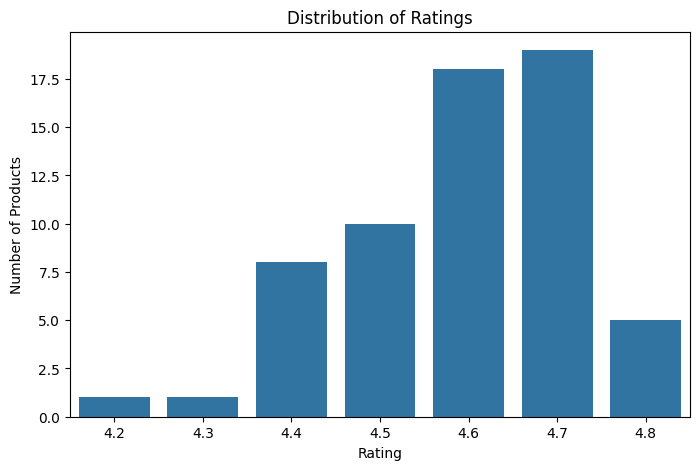

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=clean_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Products')
plt.show()


Product Count by Price Range

<ipython-input-24-2635521359>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price Range', data=clean_df, palette='Set2')


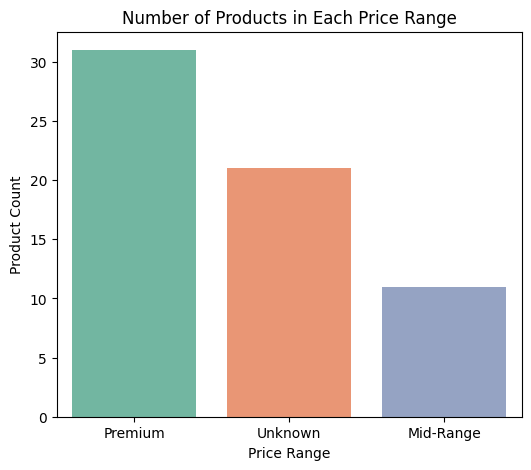

In [24]:
plt.figure(figsize=(6,5))
sns.countplot(x='Price Range', data=clean_df, palette='Set2')
plt.title('Number of Products in Each Price Range')
plt.xlabel('Price Range')
plt.ylabel('Product Count')
plt.show()


 Data Preprocessing **bold text**

In [27]:
# Load your cleaned data
df = pd.read_csv("cleaned_amazon_facewash.csv")

In [28]:
# Drop rows with missing key data
df = df.dropna(subset=["Price (INR)", "Rating", "Number of Reviews", "Tags", "Price Range"])

In [29]:
# Convert tags from string to list
df["Tags"] = df["Tags"].apply(lambda x: x.split(", "))

In [33]:
 #Encode Tags using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df["Tags"])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

In [34]:
# Combine numerical and encoded tag features
X = pd.concat([df[["Rating", "Number of Reviews"]].reset_index(drop=True), tags_df.reset_index(drop=True)], axis=1)


 Classification: Price Range

In [35]:
y_class = df["Price Range"]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

In [36]:
print("\n📊 Classification Report (Price Range):")
print(classification_report(y_test_c, y_pred_c))


📊 Classification Report (Price Range):
              precision    recall  f1-score   support

   Mid-Range       1.00      0.25      0.40         4
     Premium       0.62      1.00      0.77         5

    accuracy                           0.67         9
   macro avg       0.81      0.62      0.58         9
weighted avg       0.79      0.67      0.61         9



 Regression: Product Rating

In [37]:
y_reg = df["Rating"]
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

In [38]:
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

In [39]:
print(f"\n Regression Metrics (Rating):\nMAE: {mae:.3f}\nR² Score: {r2:.3f}")


 Regression Metrics (Rating):
MAE: 0.002
R² Score: 0.998
